In [13]:
# Install necessary packages if not already installed
# !pip install transformers torch pillow timm
# Note: Vim models may require mamba_ssm and causal_conv1d for optimized execution, 
# though some implementations might run with standard torch operations depending on the configuration.
# !pip install mamba_ssm causal_conv1d

In [14]:
import torch
from PIL import Image
import numpy as np
import torchvision.transforms as T

In [15]:
# Load DINOv2 from torch hub
# Note: Using 'dinov2_vits14' (ViT-Small) for demonstration.
# Available models: dinov2_vits14, dinov2_vitb14, dinov2_vitl14, dinov2_vitg14
# Assuming 'dinov2' as 'dinov3' is not yet standard on torch hub.
REPO = "/home/tyler/Documents/CMU/dinov3"
MODEL_NAME = "dinov3_convnext_tiny"
TINY_WEIGHTS_PATH = "/home/tyler/Documents/CMU/tmrl/tmrl/custom/models/weights/dinov3_convnext_tiny_pretrain_lvd1689m-21b726bb.pth"
BASE_WEIGHTS_PATH = "/home/tyler/Documents/CMU/tmrl/tmrl/custom/models/weights/dinov3_convnext_base_pretrain_lvd1689m-801f2ba9.pth"


print(f"Loading {MODEL_NAME} from {REPO}...")
try:
    model = torch.hub.load(REPO, MODEL_NAME, source="local", weights=TINY_WEIGHTS_PATH)
    model.eval()
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

Loading dinov3_convnext_tiny from /home/tyler/Documents/CMU/dinov3...
Model loaded successfully.


Random image created.


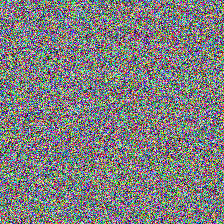

In [16]:
# Create a random image (3 channels, 224x224)
width, height = 224, 224
random_array = np.random.randint(0, 255, (height, width, 3), dtype=np.uint8)
image = Image.fromarray(random_array)

# DINOv2 expects specific transforms
transform = T.Compose([
    T.Resize(256, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

print("Random image created.")
display(image)

In [17]:
# Prepare inputs
img_tensor = transform(image).unsqueeze(0) # Add batch dimension

# Run inference
print("Running inference...")
if torch.cuda.is_available():
    model = model.cuda()
    img_tensor = img_tensor.cuda()

with torch.no_grad():
    # DINOv2 outputs features/embeddings
    output = model(img_tensor)

print(f"Output shape: {output.shape}")
print("Inference complete.")

Running inference...
Output shape: torch.Size([1, 768])
Inference complete.


In [18]:
import time

# Benchmark
num_iterations = 100
print(f"Benchmarking inference over {num_iterations} iterations...")

# Warmup
print("Warming up...")
with torch.no_grad():
    for _ in range(10):
        _ = model(img_tensor)

# Timing
if torch.cuda.is_available():
    torch.cuda.synchronize()
    
start_time = time.time()
with torch.no_grad():
    for _ in range(num_iterations):
        _ = model(img_tensor)
        if torch.cuda.is_available():
            torch.cuda.synchronize() # Wait for CUDA to finish

end_time = time.time()
avg_time = (end_time - start_time) / num_iterations
print(f"Average inference time: {avg_time * 1000:.2f} ms")
print(f"FPS: {1.0 / avg_time:.2f}")

Benchmarking inference over 100 iterations...
Warming up...


Average inference time: 2.52 ms
FPS: 397.56
